# The Transient Universe

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 




In [1]:
import emcee
import corner
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

Load the data from the file

In [42]:
fname = '../solutions/transient.npy'
data  = np.load(fname)

In [43]:
data

array([[ 0.46954762,  8.83485016,  1.        ],
       [ 1.87898004, 10.90082649,  1.        ],
       [ 2.01075462, 10.46566244,  1.        ],
       [ 2.02183974,  8.46375631,  1.        ],
       [ 3.91877923, 11.48825219,  1.        ],
       [ 6.02254716, 11.89588918,  1.        ],
       [ 6.41474963, 11.17877957,  1.        ],
       [ 7.10360582,  9.82007516,  1.        ],
       [ 8.71292997,  8.92924738,  1.        ],
       [ 9.39405108, 11.05445173,  1.        ],
       [ 9.60984079,  9.59682305,  1.        ],
       [ 9.71012758, 11.22244507,  1.        ],
       [10.20448107, 10.20827498,  1.        ],
       [11.03751412, 10.97663904,  1.        ],
       [11.82744259, 10.3563664 ,  1.        ],
       [11.8727719 , 10.70657317,  1.        ],
       [12.01965612, 10.01050002,  1.        ],
       [12.89262977, 11.78587049,  1.        ],
       [13.17978624, 10.12691209,  1.        ],
       [13.81829513, 10.40198936,  1.        ],
       [14.33532874, 11.8831507 ,  1.   

In [44]:
times    = np.array(data[:, 0])
flux     = np.array(data[:, 1])
flux_err = np.array(data[:, 2])

Text(0.5, 1.0, '$F(t)$')

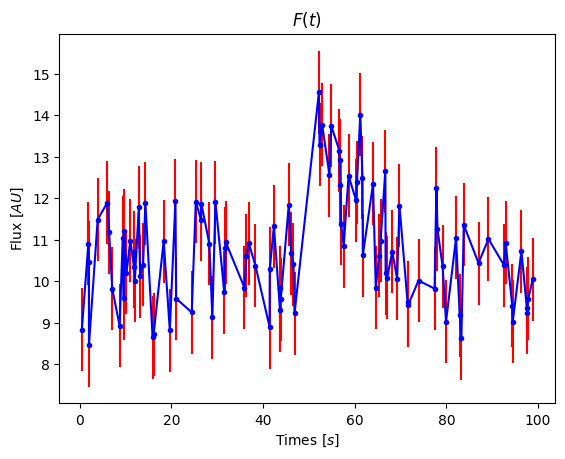

In [45]:
plt.errorbar(times, flux, flux_err, c='blue', ecolor='red', marker='.')
plt.xlabel(r'Times [$s$]')
plt.ylabel(r'Flux [$AU$]')
plt.title(r'$F(t)$')

In [46]:
def Burst_Model(parameters, t):
    b, A, t0, alpha = parameters
    
    model = []
    
    for i in range(len(t)):
        if t[i] < t0:
            model.append(b)
        
        if t[i]>= t0:
            model.append(b + A * np.exp(-alpha * (t[i] - t0)))
            
    model = np.array(model)
    
    return model


def Log_Prior(parameters):
    b, A, t0, alpha = parameters
    
    if b<0 or b>50 or A<0 or A>50 or t0<0 or t0>100 or alpha<1e-5 or alpha>1e5:
        return -np.inf
    
    else:
        return np.log(50*50*100*np.log(1e5/1e-5)*alpha)
    
def Log_Likelihood(parameters, times, flux, error):
    
    model = Burst_Model(parameters, times)
    
    return - 0.5 * np.sum(np.log(2*np.pi*error**2) + ((flux - model) / error)**2)    

def Log_Posterior (parameters, times, flux, error):
    
    log_prior = Log_Prior(parameters)
    
    if np.isfinite(log_prior):
        return log_prior + Log_Likelihood(parameters, times, flux, error)
    
    else:
        return log_prior

### Emcee

In [47]:
n_param = 4
n_walkers = 10
n_steps = 100000

np.random.seed(0)
starating_guesses = np.array([10, 5, 50, 1e-2]) + 1e-2 * np.random.randn(n_walkers, n_param)

sampler = emcee.EnsembleSampler(n_walkers, n_param, Log_Posterior, args=(times, flux, flux_err))

sampler.run_mcmc(starating_guesses, n_steps, progress=True)

samples = sampler.get_chain()

100%|█████████████████████████████████| 100000/100000 [01:31<00:00, 1098.41it/s]


### Traceplots for each parameter

Text(0.5, 0.98, 'Traceplot for Each Parameter')

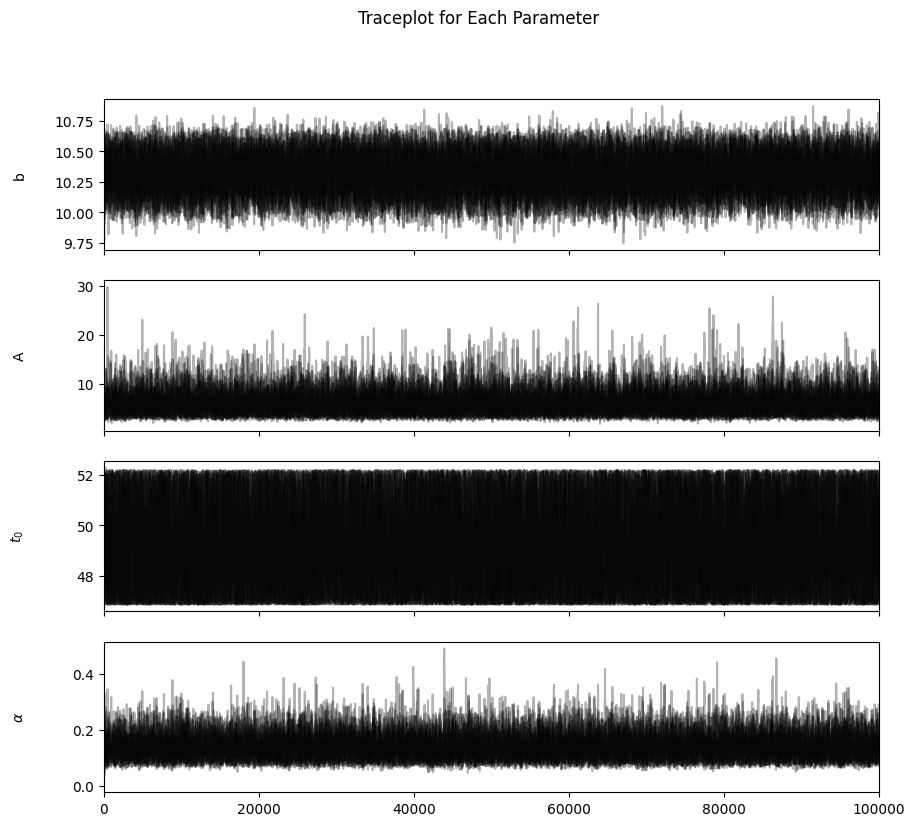

In [48]:
fig, axes = plt.subplots(4, figsize=(10,9), sharex=True)

labels = ['b', 'A', r'$t_0$', r'$\alpha$']

for i in range(n_param):
    ax = axes[i]
    ax.plot(samples[:, :, i], c="k", alpha=0.3)
    ax.set_xlim(0, 100000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
fig.suptitle('Traceplot for Each Parameter')
        

Evaluate the **Autocorrelation Time** and select the one to thin the chain accordingly.

In [49]:
tau = sampler.get_autocorr_time()
print(f'Autocorrelation Times = {tau}')

Autocorrelation Times = [70.4882719  99.39104483 94.01106331 78.22756312]


Set the $\textbf{Burning parameter}$

In [50]:
burn = 1000

# I take the maximum of the autocorrelation times
flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True) 

In [51]:
import time

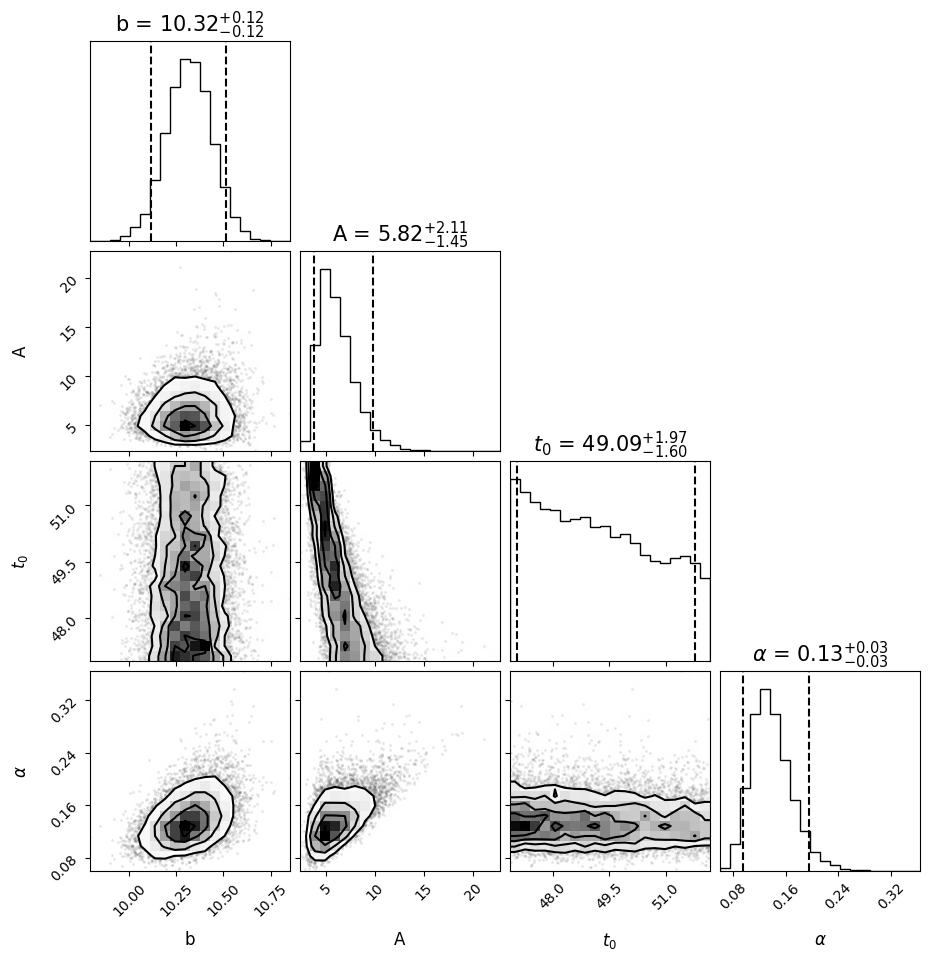

In [52]:
fig = corner.corner(
    flat_samples, 
    labels=["b", "A", r"$t_0$", r"$\alpha$"], 
    quantiles=[0.05, 0.95], 
    show_titles=True, 
    title_kwargs={"fontsize": 15}, 
    title_quantiles=[0.16, 0.5, 0.84],  # Assicurati che ci siano esattamente tre valori qui
    label_kwargs=dict(fontsize=12)
)

Try to extract  $\textbf{medians}$ and $\textbf{credibility regions}$.

In [53]:
from IPython.display import display, Math, Latex

In [54]:
labels_output = ["b", "A", "t_0", r"\alpha"]

for i in range(n_param):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])  # median is 50 percentile
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_output[i])

    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's see how is the posterior spread of model solutuons that are consinstent with the data! 

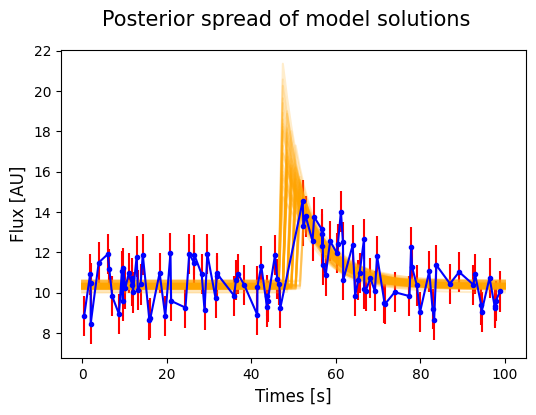

In [55]:
times_plot = np.linspace(0,100,100)

#plot section:

plt.figure(figsize=(6, 4))
plt.errorbar(times, flux, flux_err, marker='.', c="blue", ecolor='red')
plt.xlabel("Times [s]", size=12)
plt.ylabel('Flux [AU]', size=12)
plt.suptitle("Posterior spread of model solutions", size=15);


for i in range(0, 100): 
    
    chosen_post = int(stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Burst_Model(flat_samples[chosen_post], times_plot)
    
    plt.plot(times_plot, my_Model, alpha=0.2, c='orange')

## Part 2: Nested Sampling

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [56]:
import dynesty

In [76]:
# Dimensionality of our problem
n_dim = 4

# Define the TRANSFORM for the (here) uniform prior

def ptform(theta):
    b, A, t0, alpha = theta
    
    return (stats.uniform.ppf(b, 0, 50), stats.uniform.ppf(A, 0, 50), stats.uniform.ppf(t0, 0, 100), stats.loguniform.ppf(alpha, 1e-5, 1e5))


def loglikelihood_dynesty(theta):
    
    return -0.5 * np.sum(np.log(2*np.pi*flux_err**2) + ((flux-Burst_Model(theta, times))/flux_err)**2)

I used the Burst_Model defined in the first part. I now ask my sampler to evaluate the $\textit{evidence}$ I'm insterested in.

In [82]:
sampler = dynesty.NestedSampler(loglikelihood_dynesty, ptform, n_dim, nlive=1000)
sampler.run_nested()
sampler_results = sampler.results

4085it [00:14, 152.56it/s, bound: 5 | nc: 26 | ncall: 43156 | eff(%):  9.466 | loglstar:   -inf < -220.668 <    inf | logz: -229.154 +/-  0.087 | dlogz: 60.522 >  1.009]     /home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4717it [00:19, 226.09it/s, bound: 12 | nc: 23 | ncall: 52354 | eff(%):  9.010 | loglstar:   -inf < -191.072 <    inf | logz: -199.128 +/-  0.083 | dlogz: 43.696 >  1.009]/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. 

5682it [00:47, 11.44it/s, bound: 45 | nc: 210 | ncall: 103255 | eff(%):  5.503 | loglstar:   -inf < -180.721 <    inf | logz: -187.845 +/-  0.079 | dlogz: 31.425 >  1.009]/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
5689it [00:48,  9.79it/s, bound: 46 | nc: 302 | ncall: 104781 | eff(%):  5.429 | loglstar:   -inf < -180.700 <    inf | logz: -187.815 +/-  0.079 | dlogz: 31.388 >  1.009]/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If

6000it [01:08, 16.92it/s, bound: 70 | nc: 21 | ncall: 140153 | eff(%):  4.281 | loglstar:   -inf < -179.955 <    inf | logz: -186.828 +/-  0.078 | dlogz: 30.088 >  1.009] /home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
6005it [01:09,  9.12it/s, bound: 71 | nc: 183 | ncall: 142116 | eff(%):  4.225 | loglstar:   -inf < -179.943 <    inf | logz: -186.816 +/-  0.078 | dlogz: 30.071 >  1.009]/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If

7206it [02:06,  6.99it/s, bound: 149 | nc: 148 | ncall: 259171 | eff(%):  2.780 | loglstar:   -inf < -179.048 <    inf | logz: -185.443 +/-  0.076 | dlogz: 37.080 >  1.009]/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
7242it [02:10, 16.46it/s, bound: 156 | nc: 323 | ncall: 269289 | eff(%):  2.689 | loglstar:   -inf < -179.041 <    inf | logz: -185.427 +/-  0.076 | dlogz: 37.029 >  1.009] /home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large.

7645it [03:00,  8.15it/s, bound: 224 | nc: 373 | ncall: 370435 | eff(%):  2.064 | loglstar:   -inf < -179.001 <    inf | logz: -185.292 +/-  0.075 | dlogz: 36.491 >  1.009] /home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
7691it [03:07,  6.81it/s, bound: 233 | nc: 544 | ncall: 384126 | eff(%):  2.002 | loglstar:   -inf < -178.998 <    inf | logz: -185.280 +/-  0.075 | dlogz: 36.433 >  1.009]/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large.

9499it [05:19, 44.03it/s, bound: 427 | nc: 865 | ncall: 675552 | eff(%):  1.406 | loglstar:   -inf < -174.711 <    inf | logz: -184.710 +/-  0.080 | dlogz: 34.057 >  1.009]/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/ario/anaconda3/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more liv

Exception while calling prior_transform function:
  params: [0.24608127 0.00521776 0.7375761  0.31336546]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

Log the results and print them.

In [78]:
logZdynesty = sampler_results.logz[-1]          # Value of logZ
logZ_err_dynesty = sampler_results.logzerr[-1]  # Estimate of the statistical uncertainty of logZ

In [79]:
print("Marginalized evidence is {:.2f} ± {:.2f}".format(logZdynesty, logZ_err_dynesty))

Marginalized evidence is -156.16 ± 0.29


I plot the parameters traces and 1-D marginalized posteriors.

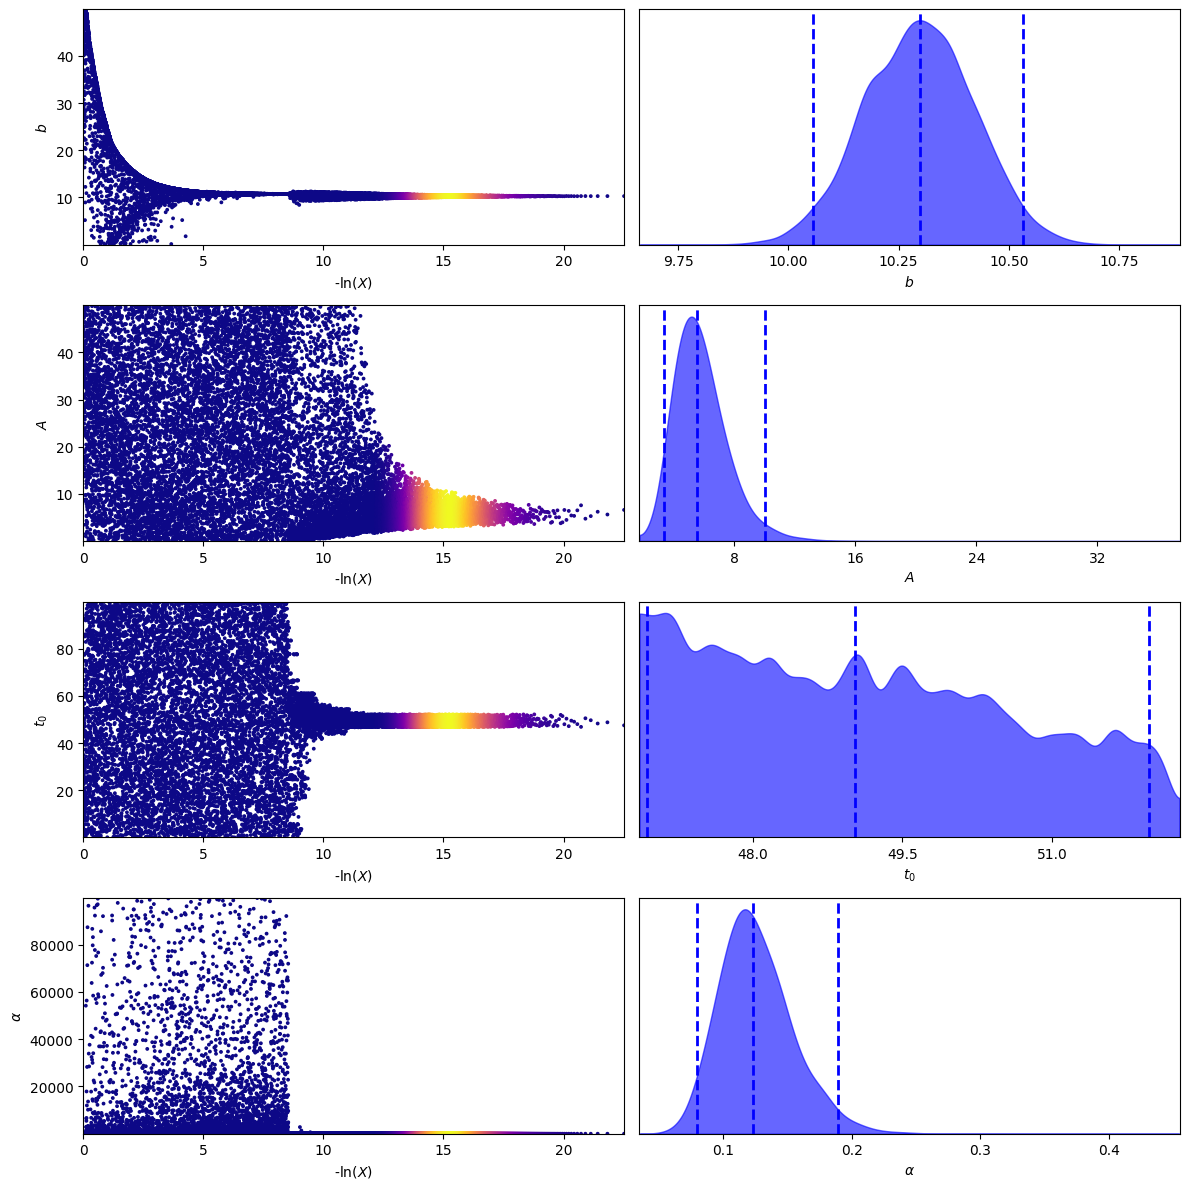

In [83]:
from dynesty import plotting as dyplot
tfig, taxes = dyplot.traceplot(sampler_results, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$b$")
taxes[0][1].set_xlabel("$b$")


taxes[1][0].set_xlabel("-$\\ln(X)$")
taxes[1][0].set_ylabel("$A$")
taxes[1][1].set_xlabel("$A$")


taxes[2][0].set_xlabel("-$\\ln(X)$")
taxes[2][0].set_ylabel("$t_0$")
taxes[2][1].set_xlabel("$t_0$")

taxes[3][0].set_xlabel("-$\\ln(X)$")
taxes[3][0].set_ylabel(r"$\alpha$")
taxes[3][1].set_xlabel(r"$\alpha$")


tfig.tight_layout()

Now we get the posterior samples.

In [ ]:
from dynestystynesty.utils import resample_equal